# Análises Exploratória dos dados de treino

## Setup e imports
Utilizamos os pacotes: *pandas, numpy, seaborn* e *matplotlib*


In [88]:
#@title
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


In [89]:
#@title
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/Shareddrives/ProjetoAM/music-inRecomendation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/ProjetoAM/music-inRecomendation


### Importação dos dados de treino


In [90]:
#@title
df=pd.read_csv('data/dados_treino.csv')
df.head()

,bateria,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas,BPM,VolMedio,PctCantada,PctRap,duracao,ano_lancamento,aovivo,modo,explicita,gostou,n_reproducao,id_cliente
0,Eletrônica,True,True,False,True,True,False,False,True,110.275495,-6.322162,72.909014,16.308793,233021,2004,False,A#,True,True,2,#ID7758
1,Acústica,False,True,False,True,False,False,False,False,117.367073,-6.509007,72.654133,0.000000,166437,1999,False,E,True,True,8,#ID7758
2,Acústica,True,False,True,False,False,False,False,False,100.134208,-12.717853,74.129557,0.000000,159426,2002,False,c,False,False,5,#ID7758
3,Eletrônica,True,False,False,True,True,False,False,True,105.056053,-8.088894,78.123907,18.818652,244636,1991,False,g,False,False,2,#ID7758
4,Acústica,False,False,True,True,False,False,False,False,95.707941,-7.564842,74.159074,0.000000,166520,2018,False,d#,False,True,7,#ID7758


## Data cleaning

Para cada uma das colunas verificar dados inconsistêntes

*e.g* 
* Tempo negativo
* % > 100


In [91]:
#@title
print("Tamanho inicial: "+str(len(df)))

df.query('duracao >0', inplace=True)
print("Músicas com duração acima de 0: "+str(len(df)))

df.query('PctCantada <= 100 & PctCantada>=0',inplace=True)
print("Porcentagem cantada entre 0 e 100: "+str(len(df)))
df.query('PctRap <= 100 & PctRap>=0',inplace=True)
print("Porcentagem de rap entre 0 e 100: "+str(len(df)))

print('músicas sem um modo definido: '+str(len(df[df.modo.isna()])))

Tamanho inicial: 4926
Músicas com duração acima de 0: 4922
Porcentagem cantada entre 0 e 100: 4922
Porcentagem de rap entre 0 e 100: 4921
músicas sem um modo definido: 438


Temos uma quantidade consideravel de musicas sem um modo definido (438).

In [92]:
#@title
df[df.modo.isna()].agg({'unique'}).loc[:,'bateria':'Tem_Instr_Cordas']

,bateria,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas
unique,"[Acústica, Eletrônica, Nenhuma]","[False, True]","[True, False]","[False, True]","[False, True]","[True, False]","[True, False]","[True, False]","[False, True]"


Percebemos que são músicas que podem possuir  todos instrumentos, inclusive os harmonicos e melódicos, o que indica que a ausência de uma tonalidade é realmente um dado faltante.

In [93]:
#@title
print('Músicas por cliente')
display(df.id_cliente.value_counts().to_frame())
print('Músicas por cliente (sem a tonalidade)')
display(df[df.modo.isna()].id_cliente.value_counts().to_frame())

Músicas por cliente


,id_cliente
#ID7758,2473
#ID4820,2448


Músicas por cliente (sem a tonalidade)


,id_cliente
#ID4820,231
#ID7758,207


Como podemos notar, por volta de 10% das músicas para cada cliente não possuem uma tonalidade indicada, o que pode ser considerada uma perda razoável de informação.

In [94]:
#@title
df.agg({'unique'})

,bateria,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas,BPM,VolMedio,PctCantada,PctRap,duracao,ano_lancamento,aovivo,modo,explicita,gostou,n_reproducao,id_cliente
unique,"[Eletrônica, Acústica, Nenhuma]","[True, False]","[True, False]","[False, True]","[True, False]","[True, False]","[False, True]","[False, True]","[True, False]","[110.275495473565, 117.367073297504, 100.13420...","[-6.3221624510694, -6.50900651603091, -12.7178...","[72.90901423020841, 72.6541325899253, 74.12955...","[16.308793195307, 0.0, 18.8186518137422, 62.53...","[233021, 166437, 159426, 244636, 166520, 18398...","[2004, 1999, 2002, 1991, 2018, 2016, 2001, 201...","[False, True]","[A#, E, c, g, d#, C#, a, f#, C, nan, d, f, F#,...","[True, False]","[True, False]","[2, 8, 5, 7, 3, 4, 6, 1, 9, 10, 11]","[#ID7758, #ID4820]"


#### Contagem do gosto das músicas por usuário


Neste pontos validamos o volume de apresentados de múscias em os usuários classificaram como gostei. Foi possível perceber que isso fica perto de 1/3 do total de mísicas apresentadsa dentro da base.

In [95]:
#@title
df.groupby('id_cliente')['gostou'].value_counts().reset_index(0).rename(columns={'gostou':'contagem'})

,id_cliente,contagem
gostou,,
False,#ID4820,1882
True,#ID4820,566
False,#ID7758,1612
True,#ID7758,861


E, a fim de atender o requisito de validação para os os usuários de forma independente, foram separados em dois dataframes distintos

In [96]:
#@title
cliente1 = df[df.id_cliente=="#ID7758"]
cliente2 = df[df.id_cliente=="#ID4820"]

#### Verificação da presença de NA nos dados

Os dados que acabam aparecendo como NA acabam atrapalahndo a análise e a aplicação de outras informaçõies dentro da base, por conta disso, acaba sendo necessário retirar as linhas com essas informações, uma vez que isso pode sujar a base.

In [97]:
#@title
df.isna().any().reset_index()

,index,0
0,bateria,False
1,Tem_Instr_Violao_Viola,False
2,Tem_Instr_Guitarra,False
3,Tem_Instr_Cavaco,False
4,Tem_Instr_Sintetizador_Teclado,False
5,Tem_Instr_Piano,False
6,Tem_Instr_Metais,False
7,Tem_Instr_Madeiras,False
8,Tem_Instr_Cordas,False
9,BPM,False


#### Análise das tonalidades
É interessante notar que os `modos` estão apresentados através das letras **maiusculas** representando **tonalidades maiores** e **minusculas** representando **tonalidades menores**, ocasionalmente na música toms acabam podem indicar ou dar uma pistas sobre o indíce de felicidade de uma música, principalmente se comparado com outros campos.

In [98]:
#@title
df['tom_menor']=df.modo.str.islower()

In [99]:
#@title
def tom(df):
  if df.tom_menor == True:
    return 'menor'
  else:
    return 'maior'
df['tom']=df.apply(tom, axis=1)

In [100]:
#@title
df.head()

,bateria,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas,BPM,VolMedio,PctCantada,PctRap,duracao,ano_lancamento,aovivo,modo,explicita,gostou,n_reproducao,id_cliente,tom_menor,tom
0,Eletrônica,True,True,False,True,True,False,False,True,110.275495,-6.322162,72.909014,16.308793,233021,2004,False,A#,True,True,2,#ID7758,False,maior
1,Acústica,False,True,False,True,False,False,False,False,117.367073,-6.509007,72.654133,0.000000,166437,1999,False,E,True,True,8,#ID7758,False,maior
2,Acústica,True,False,True,False,False,False,False,False,100.134208,-12.717853,74.129557,0.000000,159426,2002,False,c,False,False,5,#ID7758,True,menor
3,Eletrônica,True,False,False,True,True,False,False,True,105.056053,-8.088894,78.123907,18.818652,244636,1991,False,g,False,False,2,#ID7758,True,menor
4,Acústica,False,False,True,True,False,False,False,False,95.707941,-7.564842,74.159074,0.000000,166520,2018,False,d#,False,True,7,#ID7758,True,menor


In [101]:
#@title
modos_counts=df.modo.value_counts(dropna=False).reset_index()\
.rename(columns={'index':'tonalidade','modo':'contagem'})

In [102]:
#@title
modos_counts.fillna("N_spec", inplace=True)

Text(0.5, 1.0, 'Número de músicas por Tom')

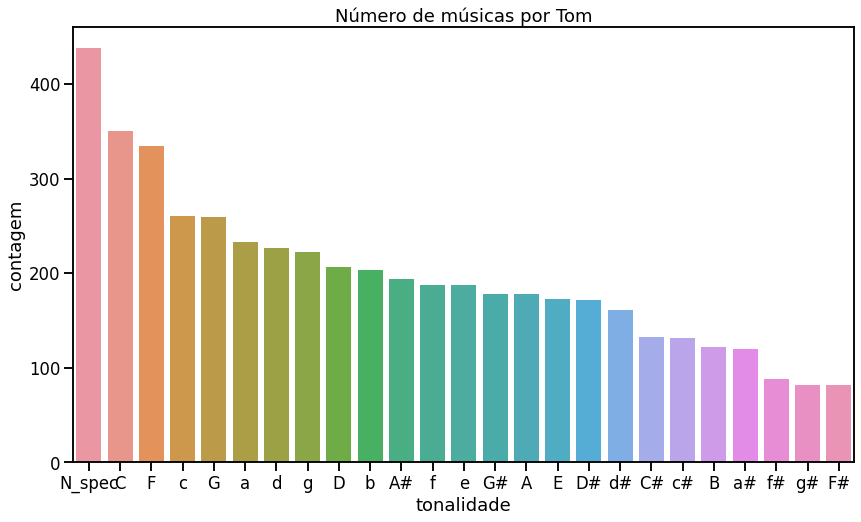

In [103]:
#@title
plt.figure(figsize=(14,8))
sns.set_context('talk')
ax=sns.barplot(x="tonalidade",y="contagem", data=modos_counts)
ax.set_title('Número de músicas por Tom')


Text(0.5, 1.0, 'Frequência em que as músicas são curtidas baseado no Tom')

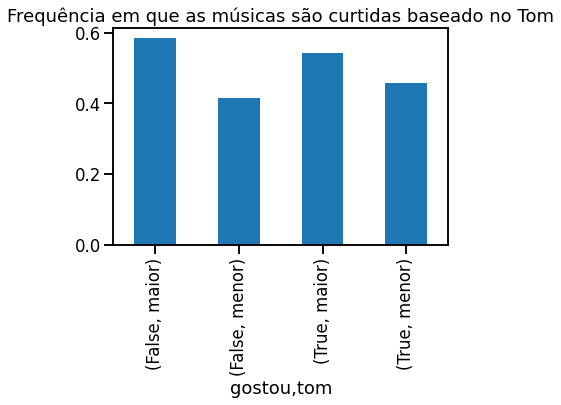

In [104]:
#@title
df.groupby('gostou')['tom'].value_counts(normalize=True).plot(kind='bar').set_title('Frequência em que as músicas são curtidas baseado no Tom')


#### Distribuição de variáveis continuas

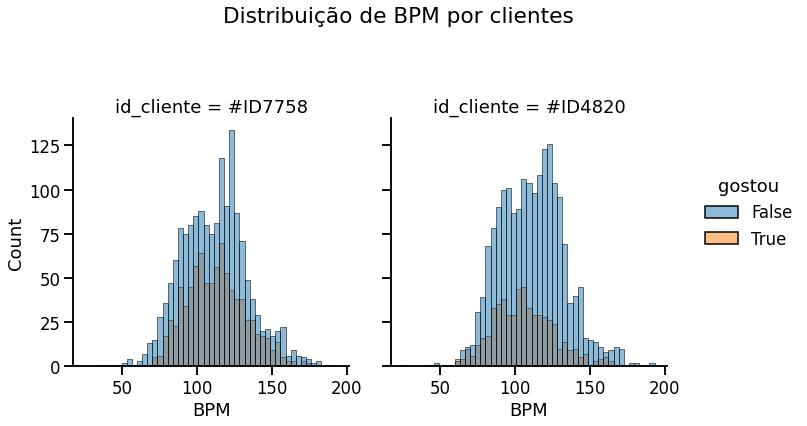

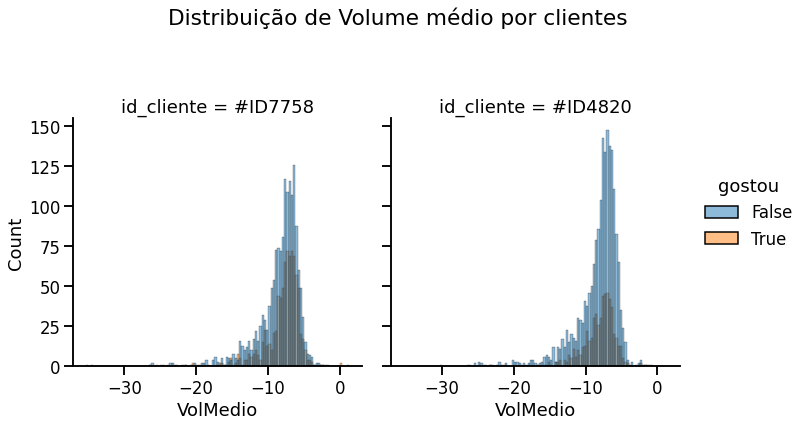

In [105]:
#@title
sns.displot(data=df, x="BPM",  hue="gostou", col="id_cliente").fig.suptitle('Distribuição de BPM por clientes', y=1.2)
plt.show()
sns.displot(data=df, x="VolMedio",  hue="gostou", col="id_cliente").fig.suptitle('Distribuição de Volume médio por clientes',y=1.2)
plt.show()


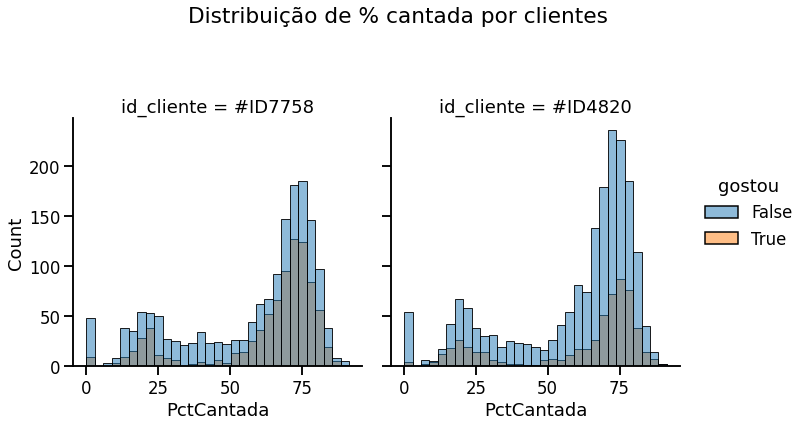

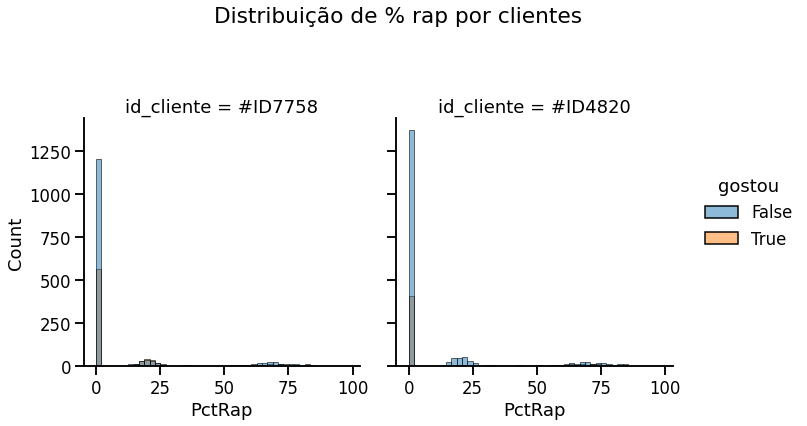

In [106]:
#@title
sns.displot(data=df, x="PctCantada", hue="gostou", col="id_cliente").fig.suptitle('Distribuição de % cantada por clientes',y=1.2)
plt.show()
sns.displot(data=df, x="PctRap", hue="gostou", col="id_cliente").fig.suptitle('Distribuição de % rap por clientes',y=1.2)
plt.show()

Text(0.5, 1.2, 'Relação de reprodução, BPM e cliente')

<Figure size 864x576 with 0 Axes>

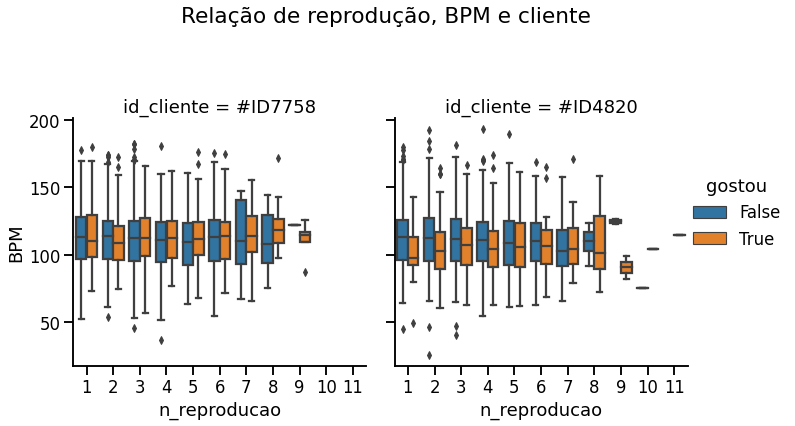

In [107]:
#@title
plt.figure(figsize=(12,8))
sns.set_context('talk')
sns.catplot(data=df, y="BPM",x="n_reproducao", hue="gostou",col="id_cliente",
            kind="box").fig.suptitle('Relação de reprodução, BPM e cliente',y=1.2)

Text(0.5, 1.2, 'Gosto e BPM por clientes')

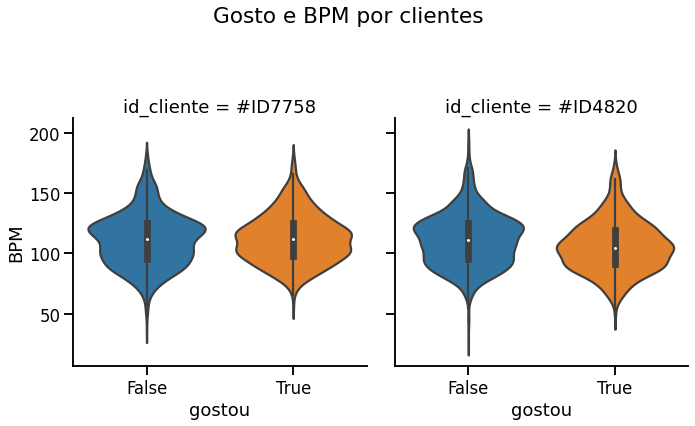

In [108]:
#@title
sns.catplot(data=df, y="BPM",x="gostou",col="id_cliente",
            kind="violin").fig.suptitle('Gosto e BPM por clientes',y=1.2)

Text(0.5, 1.2, 'Gosto e Volume médio por clientes')

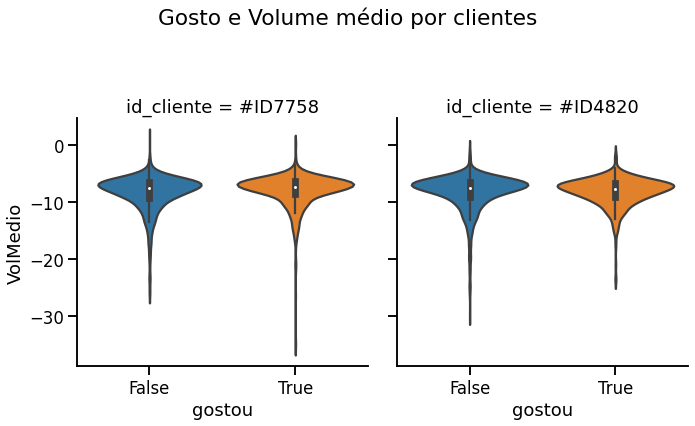

In [109]:
#@title
sns.catplot(data=df, y="VolMedio",x="gostou",col="id_cliente",
            kind="violin").fig.suptitle('Gosto e Volume médio por clientes',y=1.2)

Text(0.5, 1.0, 'Dispersão volume médio e BPM')

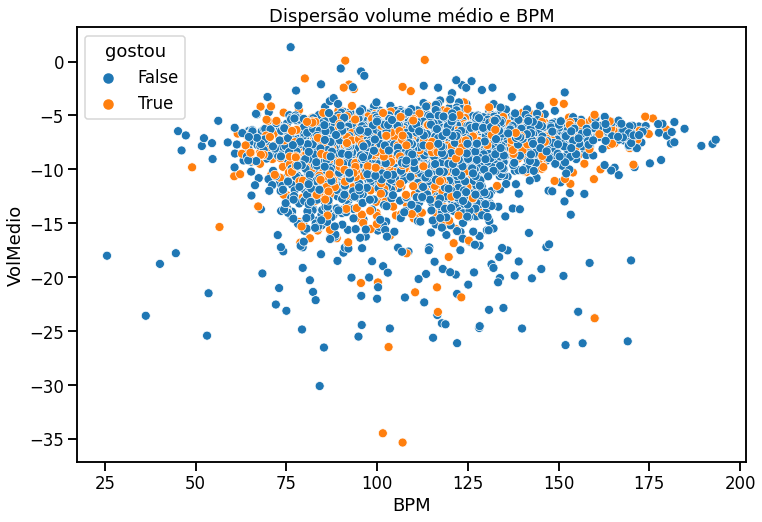

In [110]:
#@title
plt.figure(figsize=(12,8))

sns.scatterplot(data=df, y="VolMedio",x="BPM", hue="gostou").set_title('Dispersão volume médio e BPM')


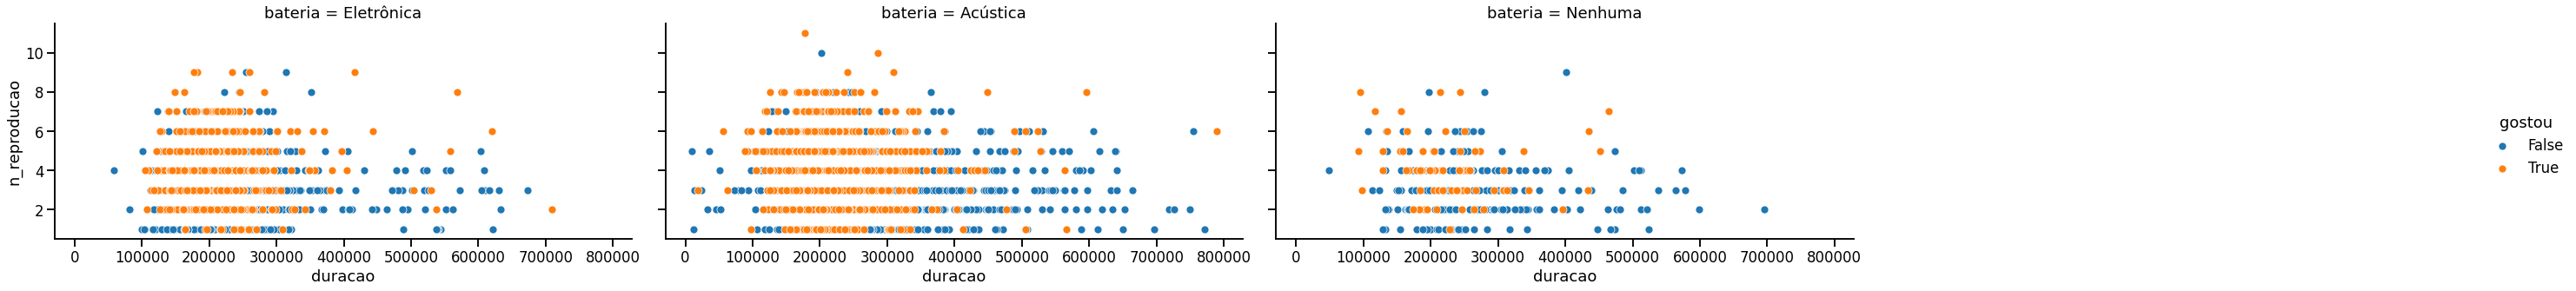

In [147]:
### TESTE TESTE TESTE TESTE

#sns.scatterplot(data=df, y="VolMedio",x="BPM", hue="gostou").set_title('Dispersão volume médio e BPM')


grid = sns.FacetGrid(df, col = "bateria", hue = "gostou", col_wrap=4, height=5, aspect=2)
grid.map(sns.scatterplot, "duracao", "n_reproducao")

grid.add_legend()

plt.show()

## Estudando a presença de instrumentos



### Matriz de Coocorrência

Número de vezes que cada instrumento aparece junto com outro

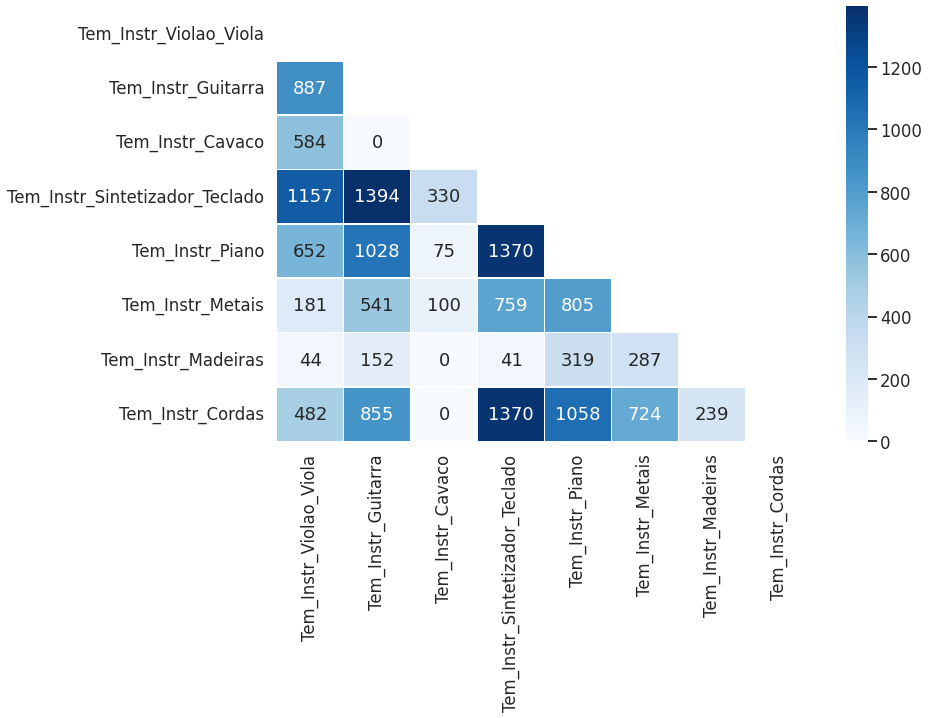

In [111]:
#@title
inst=df.loc[:,'Tem_Instr_Violao_Viola':'Tem_Instr_Cordas']
inst=inst.astype(int)
inst=inst.T.dot(inst)
sns.set_context('talk')
mask = np.zeros_like(inst)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(inst, mask=mask,linewidths=.5, annot=True,fmt="d", cmap='Blues')

### Matriz de correlação

Correlação do número de vezes que cada instrumento aparece junto com outro

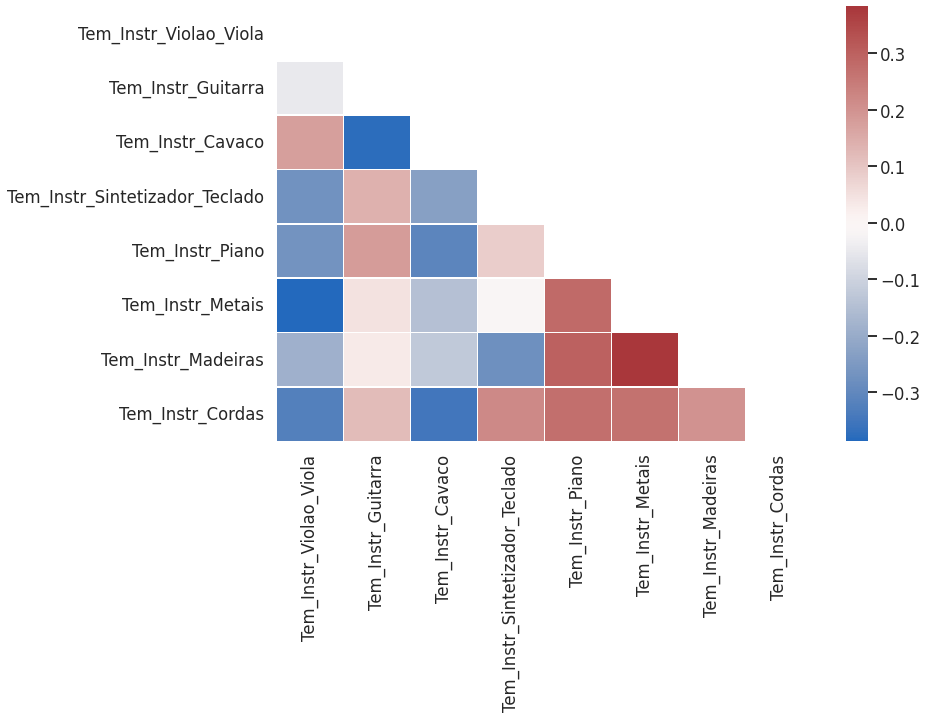

In [112]:
#@title
inst=df.loc[:,'Tem_Instr_Violao_Viola':'Tem_Instr_Cordas']
instcorr=inst.corr()
sns.set_context('talk')
mask = np.zeros_like(instcorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(instcorr, mask=mask,linewidths=.5, cmap='vlag')

Percebemos que alguns instrumentos aparecem de maneira mais consistente com outros. Da mesma forma, instrumentos como Cavaco e Guitarra dificilmente aparecem juntos.

## Explorar relação plays x gosto do usuario


Para se aprofundar um pouco mais em relação a variação de reproduções para a aceitação do usuário dentro do sistema, podemos validar pelo gráfico que a relação de músicas que o usuário não gostou acaba gerando em média menos reproduções. O que mostra um descolamento para mas médias dentro do sistema, o que indíca que possívelmente será necessário tratar os casos de exceção. mas ao mesmo tempo que pode existir umn padrão nos dados.

In [113]:
#@title
playsXgostou = df.groupby('gostou')['n_reproducao'].value_counts()

playsXgostou_n = df.groupby('gostou')['n_reproducao'].value_counts(normalize=True)
playsXgostou_n=playsXgostou_n.reset_index(0)
playsXgostou_n.rename(columns={'n_reproducao':'contagem'}, inplace=True)
playsXgostou_n=playsXgostou_n.reset_index()

Text(0.5, 1.0, 'Relação de gosto e número de reproduções')

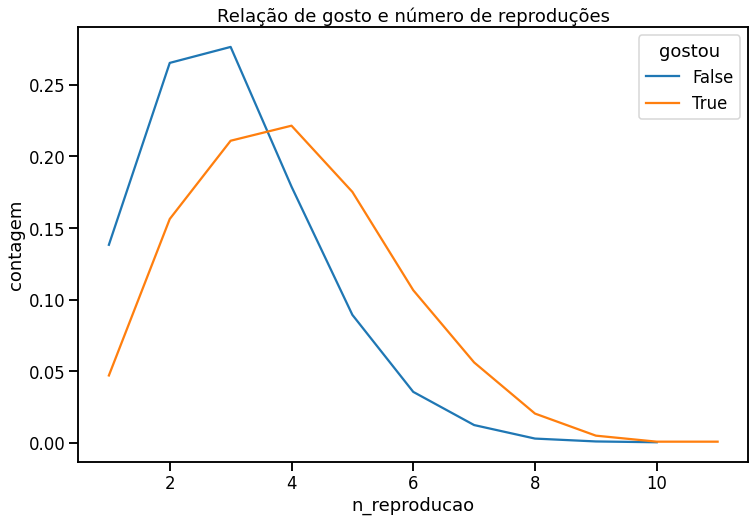

In [114]:
#@title
plt.figure(figsize=(12,8))
sns.set_context('talk')
sns.lineplot(data=playsXgostou_n, x="n_reproducao",y='contagem', hue='gostou').set_title('Relação de gosto e número de reproduções')

In [115]:
#@title
cliente1.columns

Index(['bateria', 'Tem_Instr_Violao_Viola', 'Tem_Instr_Guitarra',
       'Tem_Instr_Cavaco', 'Tem_Instr_Sintetizador_Teclado', 'Tem_Instr_Piano',
       'Tem_Instr_Metais', 'Tem_Instr_Madeiras', 'Tem_Instr_Cordas', 'BPM',
       'VolMedio', 'PctCantada', 'PctRap', 'duracao', 'ano_lancamento',
       'aovivo', 'modo', 'explicita', 'gostou', 'n_reproducao', 'id_cliente'],
      dtype='object')

## Gosto baseado no ano de lançamento e quantidade de reprodução

número de músicas que gostou no ano x / número de músicas daquele ano contidas na base


Inicialmente foi análisado a dispersão dos dados contidos dentro do intervalo de uma ano, tanto para a quantidade de repordução, quanto para a quantidade de casos que tiveram o voto de 'gostei', isso nos mostra como os dados estão inicialmente dispersos nesses casos.

In [116]:
#@title
#cliente1.groupby('ano_lancamento')['gostou'].value_counts(bins=4)
df.groupby('ano_lancamento')['gostou'].value_counts(bins=4)

ano_lancamento                  
1920            (0.9995, 1.0]         1
                (1.0005, 1.001]       0
                (1.0, 1.0005]         0
                (0.9989, 0.9995]      0
1921            (-0.0005, 0.0]        1
                                   ... 
2020            (0.25, 0.5]           0
2021            (-0.002, 0.25]      392
                (0.75, 1.0]         153
                (0.5, 0.75]           0
                (0.25, 0.5]           0
Name: gostou, Length: 384, dtype: int64

In [117]:
#@title
#cliente1.groupby('ano_lancamento')['n_reproducao'].value_counts(bins=4)
df.groupby('ano_lancamento')['n_reproducao'].value_counts(bins=4)

ano_lancamento                            
1920            (5.997, 6.0]                    1
                (6.003, 6.006]                  0
                (6.0, 6.003]                    0
                (5.992999999999999, 5.997]      0
1921            (0.9995, 1.0]                   1
                                             ... 
2020            (5.5, 7.0]                     27
2021            (0.99, 3.25]                  343
                (3.25, 5.5]                   156
                (5.5, 7.75]                    40
                (7.75, 10.0]                    6
Name: n_reproducao, Length: 384, dtype: int64

Para entender melhor a representatividade dos dados, foi utilizado um countplot do seaborn para validar o volume de musica de cada ano, dessa forma seria possível validar a necessídade de se atribiur um peso ou aplicar alguma normalização para interência dos dados, uma vez que a base pode não está uniforme quanto a quantidade em cad um dos anos.

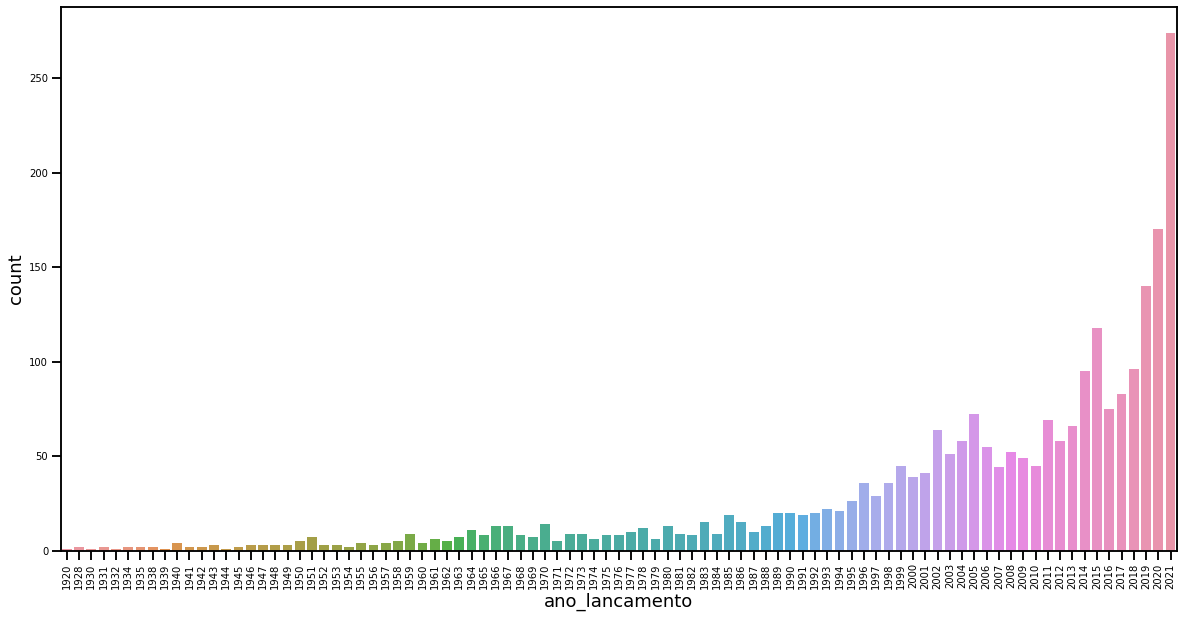

In [118]:
#@title
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
# sns.countplot(data=cliente1, x='ano_lancamento')
sns.countplot(data=cliente1, x='ano_lancamento')

Foi possível perceber que a bsae não está uniforme para os anos, o que pode levar a distorsões dos dados em relação a esse parâmetro. Com isso támbem adicionamos gráficos relacionando a média de quantidade de musicas 'gostadas' por ano e a média de vezes reproduzidas por músicas, por um ano.

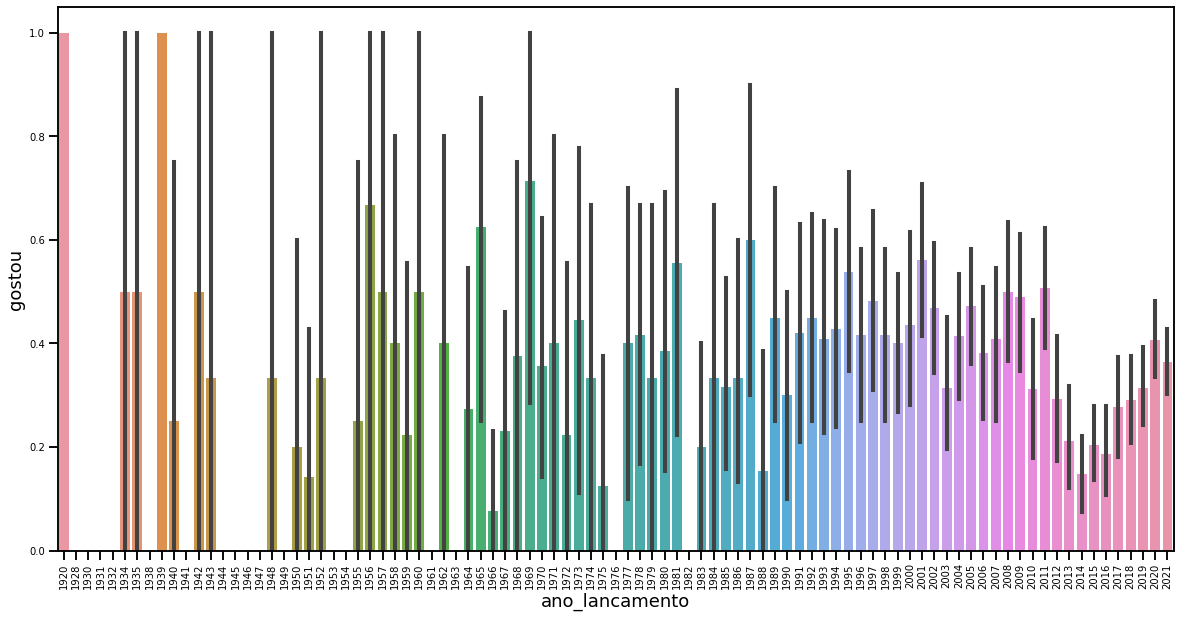

In [119]:
#@title
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
#sns.barplot(y='gostou', x='ano_lancamento', data=cliente1)
sns.barplot(y='gostou', x='ano_lancamento', data=cliente1)

Sem a incerteza temos:

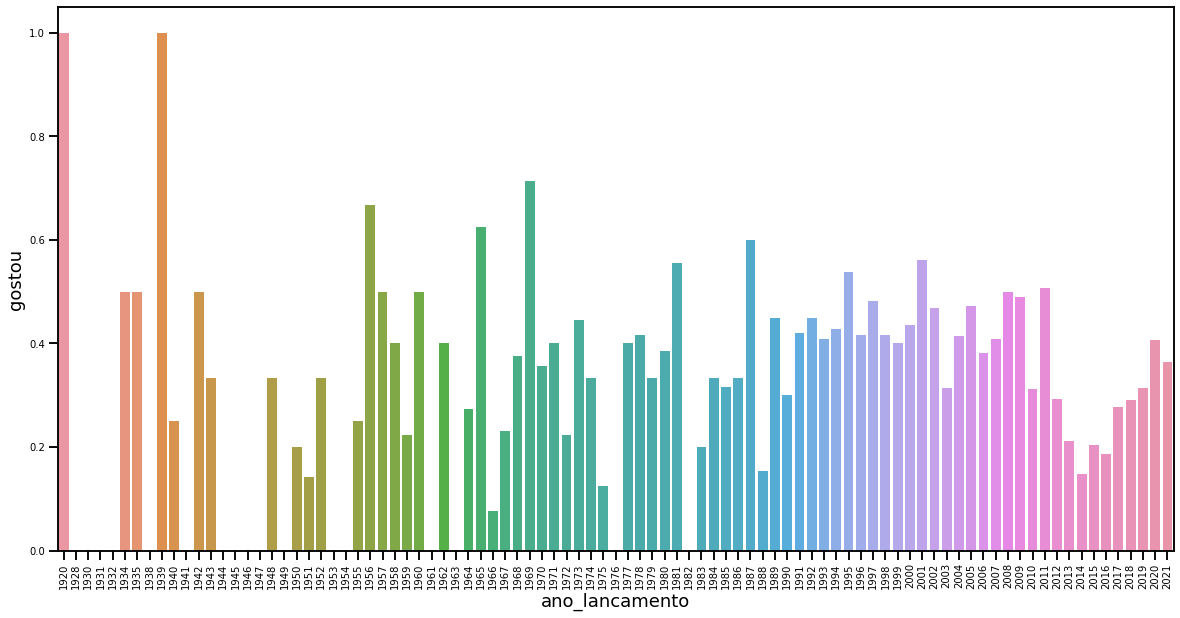

In [120]:
#@title
n_info = cliente1.groupby('ano_lancamento', as_index=False)['gostou'].mean()
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='gostou', x='ano_lancamento', data=n_info)

Para o n de reproduções, temos:

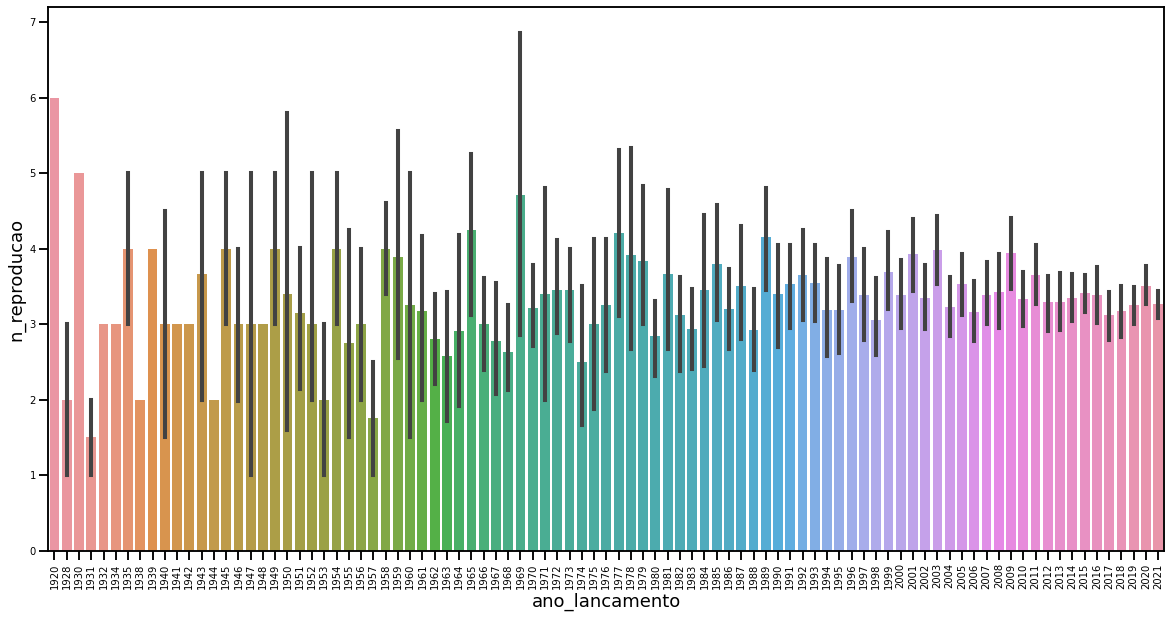

In [121]:
#@title
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='n_reproducao', x='ano_lancamento', data=cliente1)

Com isso foi possível perceber que pela baixa quantidade de dados inicialmente apresendas no inicio do século pode impactar diretamente o modelo, a incerteza para esses dados é extremamente alta, de modo que conforme os anos passam a inerteza diminui e fica mais fácil afimar se o cliente iria gostar ou não de uma música. Para isso, foi atribuido um certo peso para essa informação, gerando um fator de aceitação para esses anos e posteriormente para cada música.

In [122]:
#@title
cliente1['ano_lancamento'].value_counts()

2021    274
2020    170
2019    140
2015    118
2018     96
       ... 
1930      1
1939      1
1932      1
1944      1
1920      1
Name: ano_lancamento, Length: 91, dtype: int64

In [123]:
#@title
cliente1['ano_lancamento']/max(cliente1['ano_lancamento'].value_counts())

0       7.313869
1       7.295620
2       7.306569
3       7.266423
4       7.364964
          ...   
2470    7.361314
2471    7.354015
2472    7.375912
2473    7.335766
2474    7.321168
Name: ano_lancamento, Length: 2473, dtype: float64

In [124]:
#@title
n_info_total = cliente1.groupby('ano_lancamento', as_index=False)['gostou','n_reproducao'].mean()
n_info_total['quantidade'] = cliente1.groupby('ano_lancamento', as_index=False)['gostou'].count()['gostou']
n_info_total.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,ano_lancamento,gostou,n_reproducao,quantidade
0,1920,1.0,6.0,1
1,1928,0.0,2.0,2
2,1930,0.0,5.0,1
3,1931,0.0,1.5,2
4,1932,0.0,3.0,1


Fator de aceitação médio de ano com peso de quantidade de músicas

In [125]:
#@title
n_info_total['FA_medio_peso'] = n_info_total['gostou']*n_info_total['n_reproducao']*(n_info_total['quantidade']/max(n_info_total['quantidade']))
n_info_total

,ano_lancamento,gostou,n_reproducao,quantidade,FA_medio_peso
0,1920,1.000000,6.000000,1,0.021898
1,1928,0.000000,2.000000,2,0.000000
2,1930,0.000000,5.000000,1,0.000000
3,1931,0.000000,1.500000,2,0.000000
4,1932,0.000000,3.000000,1,0.000000
...,...,...,...,...,...
86,2017,0.277108,3.120482,83,0.261938
87,2018,0.291667,3.166667,96,0.323601
88,2019,0.314286,3.257143,140,0.523045
89,2020,0.405882,3.500000,170,0.881387


Esse peso adicionado está contido no campo FA_medio_peso, que representa o cálculo que relaciona a média dos votos de 'Gostei', a média de reproduções por ano e a normalização de quantidade de músicas por ano.

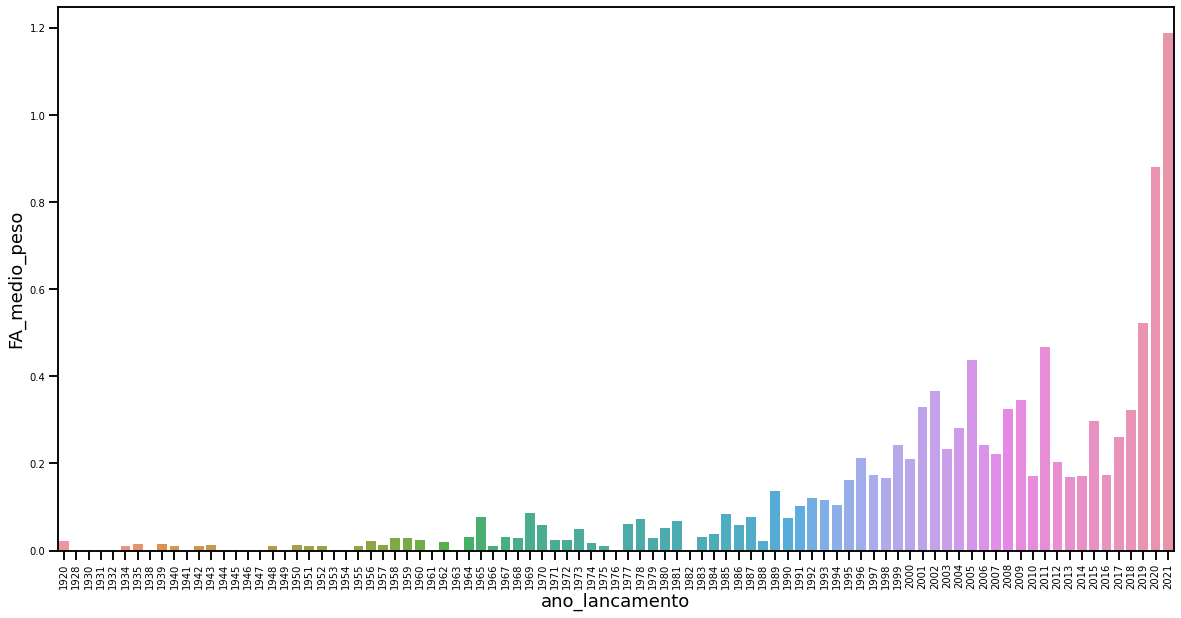

In [126]:
#@title
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_medio_peso', x='ano_lancamento', data=n_info_total)

Quqnato maior é o valor de FA_medio_peso, maior é a possibilidade de se chegar em um valor mais assertivo conforme a base de dados. Esse valor pode ser reproduzido sem o paso para casa um das músicas, o que pode ajudar a traçar uma meta para alguns campos.

Fator de aceitação de uma música:

In [127]:
#@title
cliente1['FA_musica'] = cliente1['gostou']*(cliente1['n_reproducao']/max(cliente1['n_reproducao']))
cliente1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bateria,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas,BPM,VolMedio,PctCantada,PctRap,duracao,ano_lancamento,aovivo,modo,explicita,gostou,n_reproducao,id_cliente,FA_musica
0,Eletrônica,True,True,False,True,True,False,False,True,110.275495,-6.322162,72.909014,16.308793,233021,2004,False,A#,True,True,2,#ID7758,0.222222
1,Acústica,False,True,False,True,False,False,False,False,117.367073,-6.509007,72.654133,0.000000,166437,1999,False,E,True,True,8,#ID7758,0.888889
2,Acústica,True,False,True,False,False,False,False,False,100.134208,-12.717853,74.129557,0.000000,159426,2002,False,c,False,False,5,#ID7758,0.000000
3,Eletrônica,True,False,False,True,True,False,False,True,105.056053,-8.088894,78.123907,18.818652,244636,1991,False,g,False,False,2,#ID7758,0.000000
4,Acústica,False,False,True,True,False,False,False,False,95.707941,-7.564842,74.159074,0.000000,166520,2018,False,d#,False,True,7,#ID7758,0.777778


O fator de aceitação dentro da música possibilita validar se o uma ou mais opções a cabam ficando acima ou abaixo na média, ou seja, considerando uma aceitação dentro da base geral se um ou mais elementos pode ser mais agradável ao usuário dentro de uma música.


In [128]:
#@title
cliente1['FA_musica'].value_counts()

0.000000    1612
0.444444     190
0.333333     166
0.555556     155
0.222222     131
0.666667      99
0.777778      51
0.111111      46
0.888889      18
1.000000       5
Name: FA_musica, dtype: int64

In [129]:
#@title
cliente1['FA_musica'].mean()

0.15640023363436212

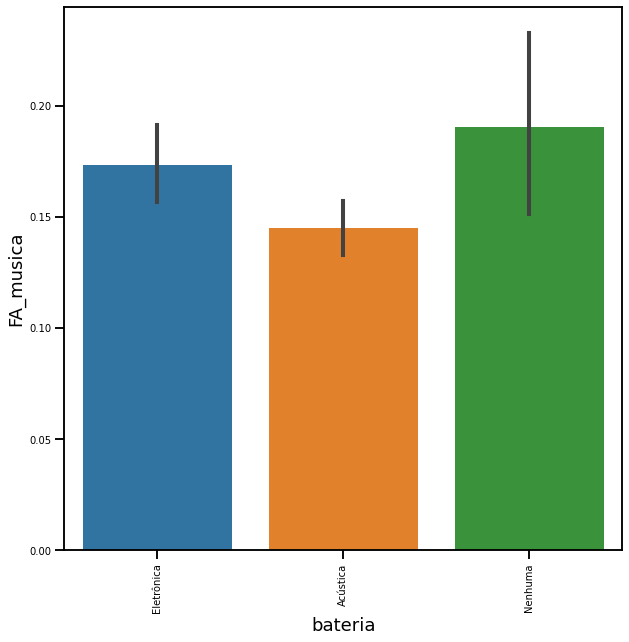

In [130]:
#@title
plt.figure(0, figsize=(10,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_musica', x='bateria', data=cliente1)

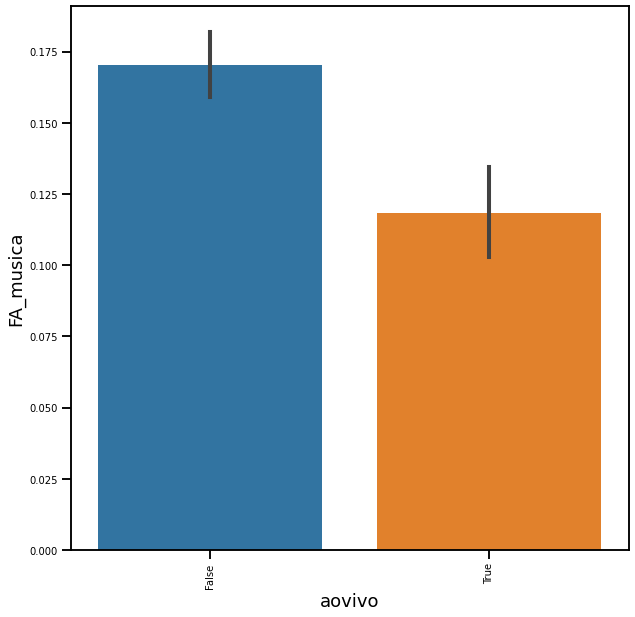

In [131]:
#@title
plt.figure(0, figsize=(10,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_musica', x='aovivo', data=cliente1)

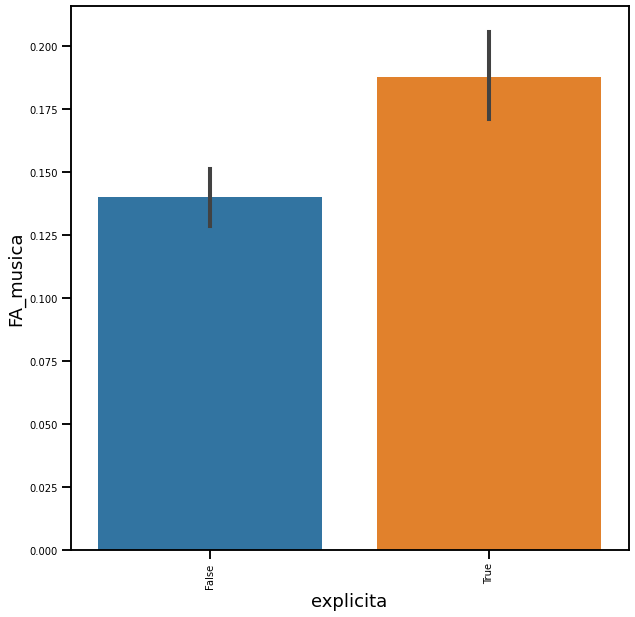

In [132]:
#@title
plt.figure(0, figsize=(10,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_musica', x='explicita', data=cliente1)

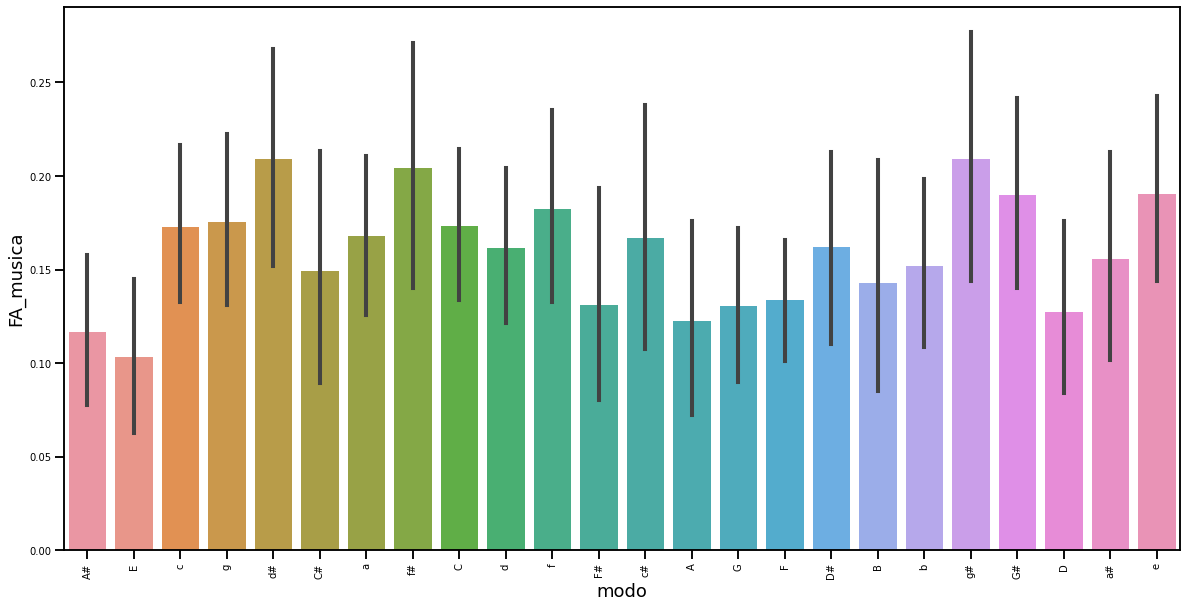

In [133]:
#@title
plt.figure(0, figsize=(20,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_musica', x='modo', data=cliente1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


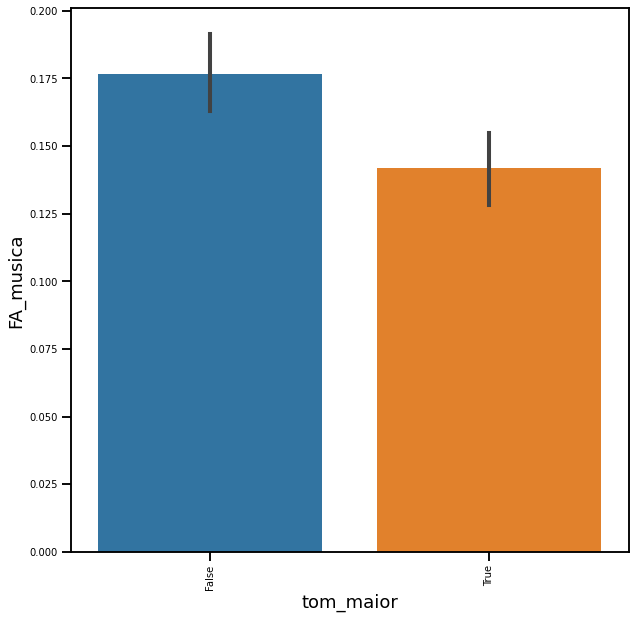

In [134]:
#@title
cliente1['tom_maior'] = cliente1['modo'].str.strip('#').str.isupper()
plt.figure(0, figsize=(10,10))
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
sns.barplot(y='FA_musica', x='tom_maior', data=cliente1)

Para isso aplicamos o gráfico de barras para alguns elementos que podem estar presente dentrop de uma música, com o fator de aceitação pode-se perceber que a média das músicas é de 0.1564, ou seja, toms menores, músicas de estúdio, e músicas explícitas ficaram acima da média global para esse usuário.